In [38]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

import joblib
from copy import deepcopy
import seaborn as sns

In [2]:
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [5]:
reduce_model = joblib.load("best/reduce_model.pkl")
c_model = joblib.load("best/c_model.pkl")

In [6]:
main_reduced = reduce_model.transform(dataset)

In [70]:
def clf_per_seed(n=10, metric = ClassifierModel.score):
    clfs = deepcopy(c_model)
    result = {name: [0.]*n for name in clfs.models}
    for seed in range(0, n):
        X_train, X_test, y_train, y_test = train_test_split(
        main_reduced, target.values.ravel(), test_size=0.2, random_state=seed,
        #stratify=target.values.ravel()
        )
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for clf in clfs.models:
            clfs.models[clf].fit(X_train, y_train)
            result[clf][seed] = metric(y_test, clfs.models[clf].predict(X_test))
    
    
    
    return result





    

In [71]:
r = pd.DataFrame(clf_per_seed(50))

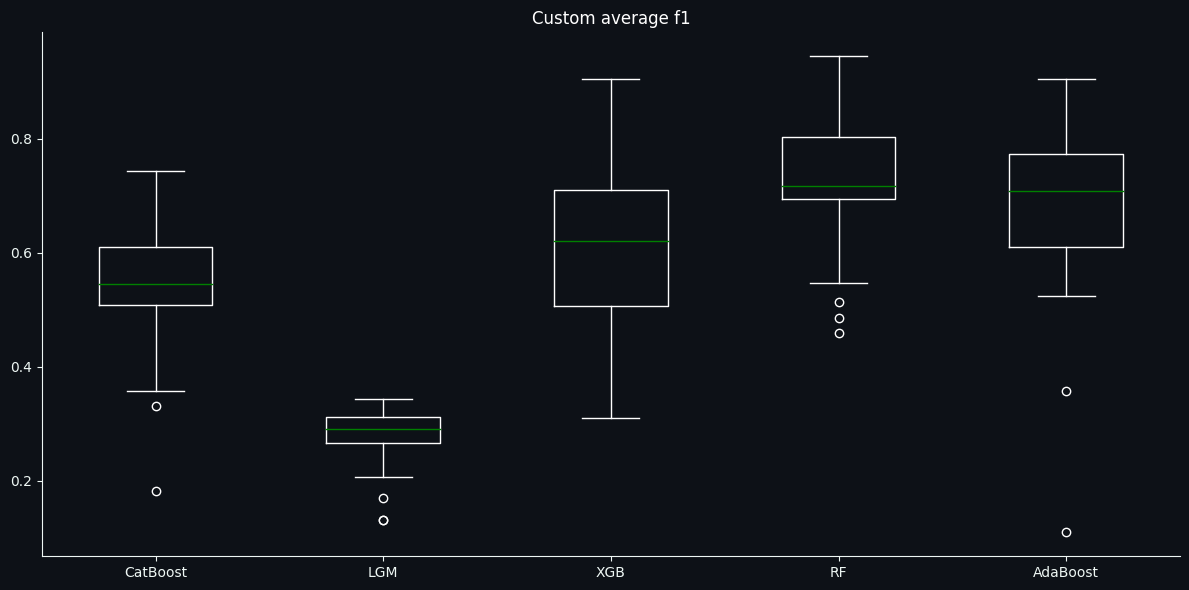

In [72]:
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="w"),
            capprops=dict(color="w"),
            whiskerprops=dict(color="w"),
            medianprops=dict(color="g"),
            flierprops=dict(color="w", markeredgecolor="w"),
            )
plt.title("Custom average f1")
plt.tight_layout()
plt.show()

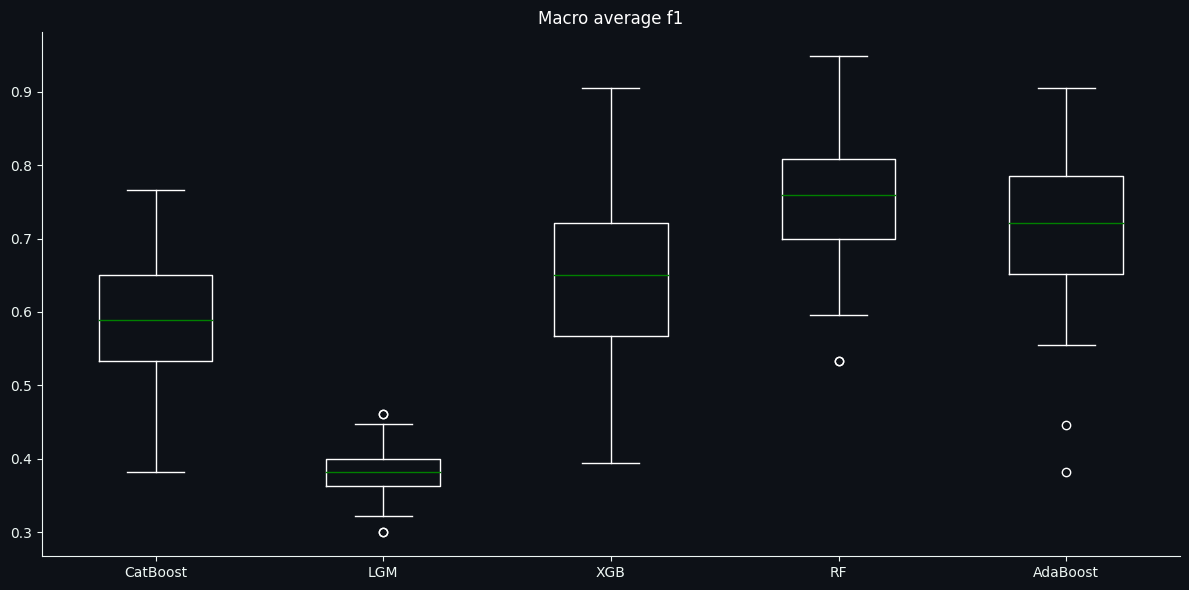

In [73]:
r = pd.DataFrame(clf_per_seed(50, lambda y_t, y_p: metrics.f1_score(y_t, y_p, average="macro")))
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="w"),
            capprops=dict(color="w"),
            whiskerprops=dict(color="w"),
            medianprops=dict(color="g"),
            flierprops=dict(color="w", markeredgecolor="w"),
            )
plt.title("Macro average f1")
plt.tight_layout()
plt.show()

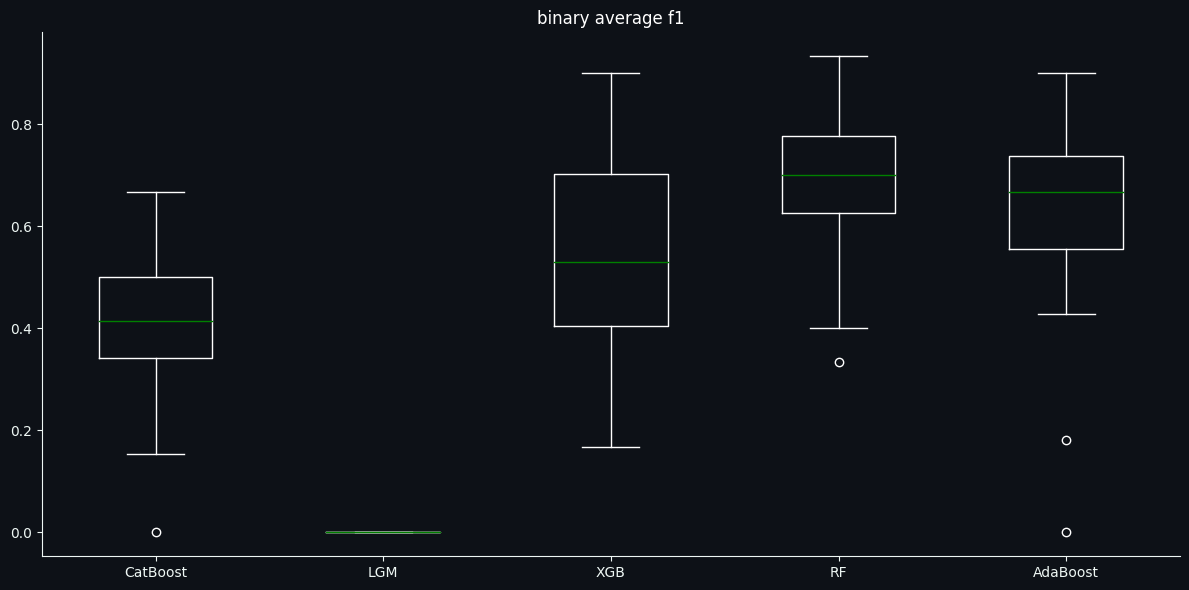

In [74]:
r = pd.DataFrame(clf_per_seed(50, lambda y_t, y_p: metrics.f1_score(y_t, y_p, pos_label=1)))
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="w"),
            capprops=dict(color="w"),
            whiskerprops=dict(color="w"),
            medianprops=dict(color="g"),
            flierprops=dict(color="w", markeredgecolor="w"),
            )
plt.title("binary average f1")
plt.tight_layout()
plt.show()

In [75]:
def clf_per_ls_dim(dim):
    reduce_model = ReduceModel(model="AE", layers=(1169, 500, 200, dim))
    reduce_model.train(epochs=60, lr=1e-3)

    main_reduced = reduce_model.transform(dataset)

    X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    c_model = ClassifierModel()
    res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)
    c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
    c_model.fit(X_train, y_train)
    res = {"model": deepcopy(c_model),
                "data": [X_train.__deepcopy__(), X_test.__deepcopy__(), y_train.__deepcopy__(), y_test.__deepcopy__()]}
    for name in c_model.models:
        pred = c_model.models[name].predict(X_test)
        print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
        print(metrics.classification_report(y_test, pred))
    return res

In [ ]:
store = {i: clf_per_ls_dim(i) for i in [20, 10, 8, 6, 5]}
